In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
import time
from tensorflow.keras.losses import Loss
from tensorflow.keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/saptarshimallikthakur/Desktop/tracking/McD /SSD 300/cropped_images_metadata.csv")
df

,img_path,obj_name
0,crop/1.jpg,maharaja mac veg
1,crop/2.jpg,McSpicy Paneer
2,crop/3.jpg,McCheese Burger Veg
3,crop/4.jpg,mcspicy premium veg burger
4,crop/5.jpg,maharaja mac veg
...,...,...
1125,crop/1126.jpg,mcwrap paneer
1126,crop/1127.jpg,McSpicy Paneer
1127,crop/1128.jpg,Medium French Fries
1128,crop/1129.jpg,BigSpicy Mcwrap Chicken


In [3]:
df['obj_name'].value_counts()

obj_name
Chicken McNuggets             160
Mcflurry Small                106
Medium French Fries            95
BigSpicy Mcwrap Chicken        58
McSpicy Paneer                 56
mcwrap paneer                  55
Mc Cheese Burger Chicken       51
McCrispy Chicken Burger        49
McCheese Burger Veg            46
mcveggie                       45
Maharaja Mac Chicken           45
Fish Fillet                    43
Mcspicy chicken                43
Crispy Veggie Burger           43
mcaloo tickki burger           43
mcspicy premium veg burger     41
Hot cakes                      34
maharaja mac veg               32
corn cheese veg burger         27
small french fries             24
spinach corn                   21
dosa bun                        7
cold drink                      6
Name: count, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

# Use df2 instead of df
df_train, df_val = train_test_split(df, test_size=0.3, stratify=df['obj_name'], random_state=42)
#df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

In [5]:
df2 = (
    df_train.groupby('obj_name', group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), 5), random_state=42))
      [['img_path', 'obj_name']]
      .reset_index(drop=True)
)

df2

/var/folders/17/w3818qh1047crr4wkhgmjkvh0000gn/T/ipykernel_9114/275138963.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 5), random_state=42))


,img_path,obj_name
0,crop/732.jpg,BigSpicy Mcwrap Chicken
1,crop/639.jpg,BigSpicy Mcwrap Chicken
2,crop/571.jpg,BigSpicy Mcwrap Chicken
3,crop/430.jpg,BigSpicy Mcwrap Chicken
4,crop/929.jpg,BigSpicy Mcwrap Chicken
...,...,...
109,crop/1029.jpg,spinach corn
110,crop/1082.jpg,spinach corn
111,crop/1052.jpg,spinach corn
112,crop/1035.jpg,spinach corn


In [6]:
df2['obj_name'].value_counts()

obj_name
BigSpicy Mcwrap Chicken       5
Chicken McNuggets             5
small french fries            5
mcwrap paneer                 5
mcveggie                      5
mcspicy premium veg burger    5
mcaloo tickki burger          5
maharaja mac veg              5
dosa bun                      5
corn cheese veg burger        5
Medium French Fries           5
Mcspicy chicken               5
Mcflurry Small                5
McSpicy Paneer                5
McCrispy Chicken Burger       5
McCheese Burger Veg           5
Mc Cheese Burger Chicken      5
Maharaja Mac Chicken          5
Hot cakes                     5
Fish Fillet                   5
Crispy Veggie Burger          5
spinach corn                  5
cold drink                    4
Name: count, dtype: int64

# augment

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

def bright(img):
    # Ensure input is in range [0, 1]
    img = np.clip(img, 0.0, 1.0)

    # ---- Brightness ----
    brightness_factor = random.uniform(0.4, 0.8)
    img_bright = img * brightness_factor
    img_bright = np.clip(img_bright, 0.0, 1.0)

    img_bright = np.clip(img_bright, 0.0, 1.0)

    return img_bright

def contrast(img):

    # Ensure input is in range [0, 1]
    img = np.clip(img, 0.0, 1.0)

    # ---- Contrast ----
    contrast_factor = random.uniform(1.1,2.5)
    mean = np.mean(img, axis=(0,1), keepdims=True)
    img_contrast = (img - mean) * contrast_factor + mean
    img_contrast = np.clip(img_contrast, 0.0, 1.0)

    img_contrast = np.clip(img_contrast, 0.0, 1.0)

    return img_contrast

def saturation(img):

    # Ensure input is in range [0, 1]
    img = np.clip(img, 0.0, 1.0)

    # ---- Hue ----
    hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    # ---- Saturation ----
    saturation_factor = random.uniform(0.9,2.5)
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation_factor, 0, 255)

    # Convert back to RGB
    img_aug = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32) / 255.0
    img_aug = np.clip(img_aug, 0.0, 1.0)

    return img_aug


def augment_and_save_images(df, save_dir='augmented_images_finetune'):
    os.makedirs(save_dir, exist_ok=True)
    
    new_data = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        path = '/Users/saptarshimallikthakur/Desktop/tracking/McD /SSD 300/'+row['img_path']
        label = row['obj_name']
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_shape = img.shape[:2]  # (H, W)

        base_name = os.path.splitext(os.path.basename(path))[0]

        def save(img, suffix):
            aug_path = os.path.join(save_dir, f"{base_name}_{suffix}.jpg")
            img_uint8 = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
            cv2.imwrite(aug_path, img_uint8)
            new_data.append({'img_path': aug_path, 'obj_name': label})

        # Normalize image
        img = img / 255.0

        # Define all 6 augmentations
        aug_imgs = {
            'orig': img,
            'hflip': np.fliplr(img),
            'vflip': np.flipud(img),
            'rot90': np.rot90(img, 1),
            'rot180': np.rot90(img, 2),
            'rot270': np.rot90(img, 3),
        }

        # For each augmentation, add original, downsample-1/2, downsample-1/4 versions
        for suffix, aug_imgg in aug_imgs.items():

            aug_img = aug_imgg.copy()
            save(aug_img, f"{suffix}_orig")

            img_saturate = saturation(aug_img)
            save(img_saturate, f"{suffix}_saturate")

            img_contrast = contrast(aug_img)
            save(img_contrast, f"{suffix}_contrast")

            img_bright = bright(aug_img)
            save(img_bright, f"{suffix}_bright")   

            # 1/2 downsample then upsample
            h, w = original_shape
            down2 = cv2.resize(aug_img, (w // 6, h // 6), interpolation=cv2.INTER_AREA)
            up2 = cv2.resize(down2, (w, h), interpolation=cv2.INTER_LINEAR)
            save(up2, f"{suffix}_down2x")

    return pd.DataFrame(new_data)

df2_augmented = augment_and_save_images(df2)

100%|██████████| 114/114 [00:26<00:00,  4.36it/s]


In [8]:
df2 = df2_augmented.copy()

In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Original labels (string/object names)
labels = np.array(df2['obj_name'])

# Get unique class names and sort them (like LabelEncoder does)
class_names = np.unique(labels)  # Equivalent to label_encoder.classes_
num_classes = len(class_names)

# Create mapping from label to integer
label_to_index = {label: idx for idx, label in enumerate(class_names)}
index_to_label = {idx: label for label, idx in label_to_index.items()}  # For inverse later

# Encode labels
encoded_labels = np.array([label_to_index[label] for label in labels])

# One-hot encode for softmax classification
label_cat = to_categorical(encoded_labels, num_classes=num_classes)

# Update df2
df2['label'] = encoded_labels
df2['label_cat'] = list(label_cat)

df2

,img_path,obj_name,label,label_cat
0,augmented_images_finetune/732_orig_orig.jpg,BigSpicy Mcwrap Chicken,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,augmented_images_finetune/732_orig_saturate.jpg,BigSpicy Mcwrap Chicken,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,augmented_images_finetune/732_orig_contrast.jpg,BigSpicy Mcwrap Chicken,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,augmented_images_finetune/732_orig_bright.jpg,BigSpicy Mcwrap Chicken,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,augmented_images_finetune/732_orig_down2x.jpg,BigSpicy Mcwrap Chicken,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
3415,augmented_images_finetune/1058_rot270_orig.jpg,spinach corn,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3416,augmented_images_finetune/1058_rot270_saturate...,spinach corn,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3417,augmented_images_finetune/1058_rot270_contrast...,spinach corn,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3418,augmented_images_finetune/1058_rot270_bright.jpg,spinach corn,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
class_names

array(['BigSpicy Mcwrap Chicken', 'Chicken McNuggets',
       'Crispy Veggie Burger', 'Fish Fillet', 'Hot cakes',
       'Maharaja Mac Chicken', 'Mc Cheese Burger Chicken',
       'McCheese Burger Veg', 'McCrispy Chicken Burger', 'McSpicy Paneer',
       'Mcflurry Small', 'Mcspicy chicken', 'Medium French Fries',
       'cold drink', 'corn cheese veg burger', 'dosa bun',
       'maharaja mac veg', 'mcaloo tickki burger',
       'mcspicy premium veg burger', 'mcveggie', 'mcwrap paneer',
       'small french fries', 'spinach corn'], dtype=object)

In [12]:
df_val = df_val.reset_index(drop=True)

# Step 3: Encode labels using NumPy mapping
df_val['label'] = df_val['obj_name'].map(label_to_index)

# Step 4: One-hot encode for softmax classification
num_classes = len(class_names)
df_val['label_cat'] = list(to_categorical(df_val['label'], num_classes=num_classes))

# Step 5: Update image path
df_val['img_path'] = df_val['img_path'].apply(lambda x: '/Users/saptarshimallikthakur/Desktop/tracking/McD /SSD 300/' + x)

df_val

,img_path,obj_name,label,label_cat
0,/Users/saptarshimallikthakur/Desktop/tracking/...,Mcflurry Small,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,/Users/saptarshimallikthakur/Desktop/tracking/...,mcaloo tickki burger,17,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,/Users/saptarshimallikthakur/Desktop/tracking/...,Chicken McNuggets,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,/Users/saptarshimallikthakur/Desktop/tracking/...,BigSpicy Mcwrap Chicken,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,/Users/saptarshimallikthakur/Desktop/tracking/...,cold drink,13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
334,/Users/saptarshimallikthakur/Desktop/tracking/...,mcveggie,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
335,/Users/saptarshimallikthakur/Desktop/tracking/...,mcveggie,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
336,/Users/saptarshimallikthakur/Desktop/tracking/...,McSpicy Paneer,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
337,/Users/saptarshimallikthakur/Desktop/tracking/...,dosa bun,15,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
df2['obj_name'].value_counts()

obj_name
BigSpicy Mcwrap Chicken       150
Chicken McNuggets             150
small french fries            150
mcwrap paneer                 150
mcveggie                      150
mcspicy premium veg burger    150
mcaloo tickki burger          150
maharaja mac veg              150
dosa bun                      150
corn cheese veg burger        150
Medium French Fries           150
Mcspicy chicken               150
Mcflurry Small                150
McSpicy Paneer                150
McCrispy Chicken Burger       150
McCheese Burger Veg           150
Mc Cheese Burger Chicken      150
Maharaja Mac Chicken          150
Hot cakes                     150
Fish Fillet                   150
Crispy Veggie Burger          150
spinach corn                  150
cold drink                    120
Name: count, dtype: int64

In [14]:
num_classes

23

In [15]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

pth = f'/Users/saptarshimallikthakur/Desktop/tracking/McD /SSD 300/ss/ss1.png'
img = cv2.imread(pth)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
np.sum(preprocess_input(img) -img)

np.uint64(0)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

def build_light_mobilenetv3_model(input_shape=(224, 224, 3), num_classes=10, dropout_rate=0.1):
    # Base model with pretrained weights and no top
    base_model = MobileNetV3Small(input_shape=input_shape, weights=None, include_top=False, pooling='avg')
    base_model.load_weights("weights_mobilenet_v3_small_224_1.0_float_no_top_v2.h5")
    base_model.trainable = False  # Freeze all layers initially

    # Input
    inputs = tf.keras.Input(shape=input_shape)
    
    # Preprocessing
    x = preprocess_input(inputs)

    # Base model
    x = base_model(x, training=False)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    return model

model = build_light_mobilenetv3_model(num_classes=num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1744022188.556570  756350 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744022188.556589  756350 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 576)            │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 977,543 (3.73 MB)

 Trainable params: 38,423 (150.09 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

def robust_load_image(image_path, label):
    def _load_image(path):
        path = path.numpy().decode('utf-8')
        try:
            img = cv2.imread(path)
            if img is None:
                # Return a black image if corrupted
                img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
            return img.astype(np.float32)
        except:
            # Handle unexpected errors
            return np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
    
    img = tf.py_function(func=_load_image, inp=[image_path], Tout=tf.float32)
    img.set_shape((IMG_SIZE[0], IMG_SIZE[1], 3))
    return img, label


def df_to_dataset(df):
    paths = df['img_path'].values
    labels = np.stack(df['label_cat'].values)  # convert list of arrays to proper shape
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(robust_load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


train_ds = df_to_dataset(df2)
val_ds = df_to_dataset(df_val)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)

history = model.fit(
    train_ds,
    epochs=35,
    validation_data=val_ds,
    callbacks=[early_stop, lr_schedule]
)

Epoch 1/35
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.1002 - loss: 3.4502 - val_accuracy: 0.2212 - val_loss: 2.6342 - learning_rate: 1.0000e-04
Epoch 2/35
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.3738 - loss: 2.1999 - val_accuracy: 0.4720 - val_loss: 1.9569 - learning_rate: 1.0000e-04
Epoch 3/35
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6725 - loss: 1.5038 - val_accuracy: 0.6667 - val_loss: 1.4570 - learning_rate: 1.0000e-04
Epoch 4/35
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8418 - loss: 1.0311 - val_accuracy: 0.7640 - val_loss: 1.1184 - learning_rate: 1.0000e-04
Epoch 5/35
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9053 - loss: 0.7311 - val_accuracy: 0.8201 - val_loss: 0.8899 - learning_rate: 1.0000e-04
Epoch 6/35
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9307 - loss: 0.5387 - val_accuracy: 0.8496 - val_loss: 0.7387 - learning_rate: 1.0000e-04
Epoch 7/35
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/st

In [19]:
def load_and_preprocess_image(path,IMG_SIZE=(224,224)):
    img = cv2.imread(path)
    if img is None:
        img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img.astype(np.float32)
    return img

I0000 00:00:1744024353.386623  780658 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744024353.386641  780658 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


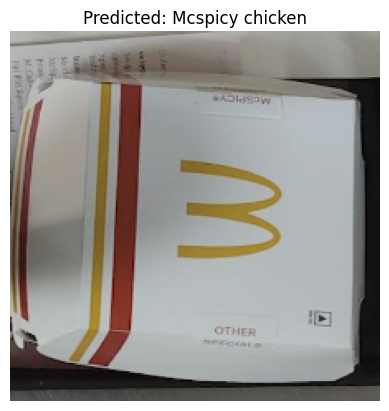

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


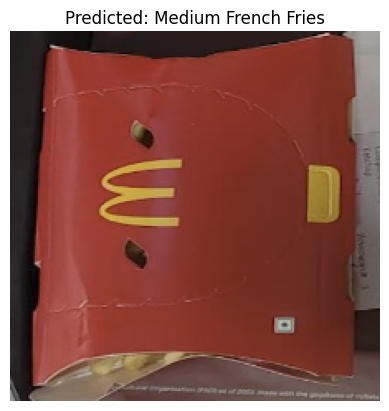

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


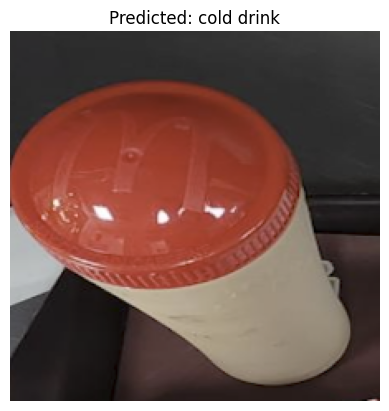

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


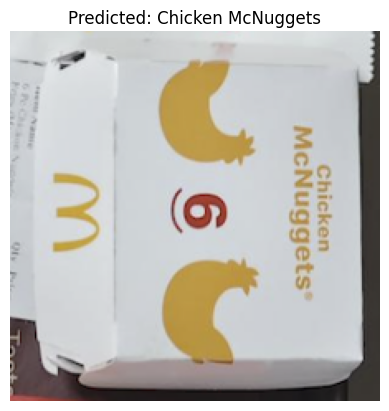

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


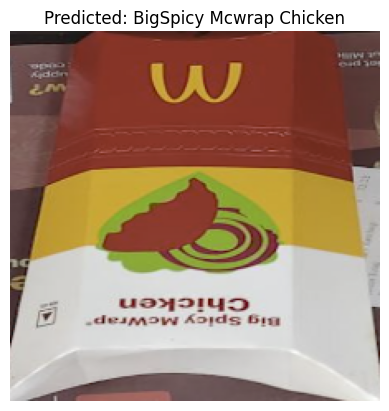

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


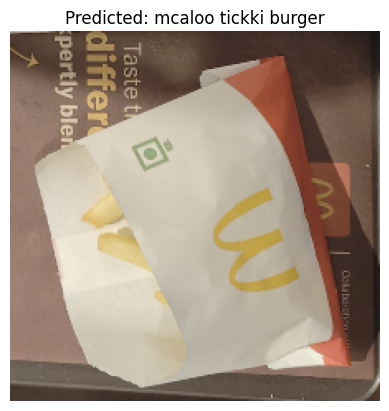

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


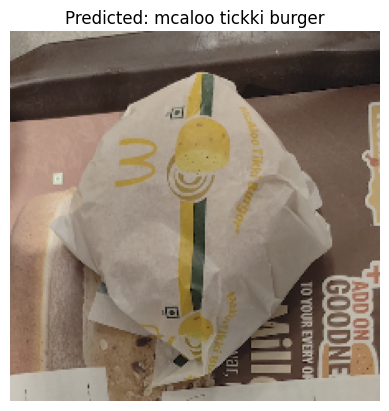

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


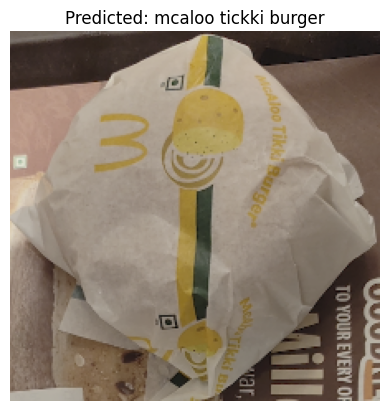

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


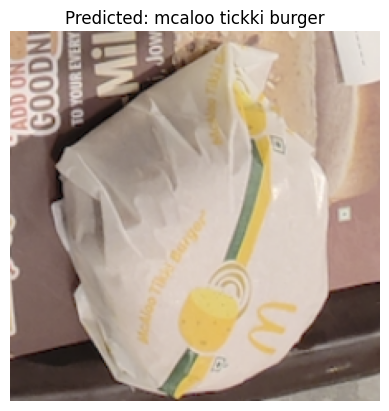

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


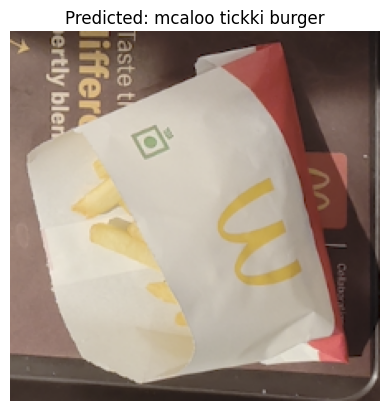

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


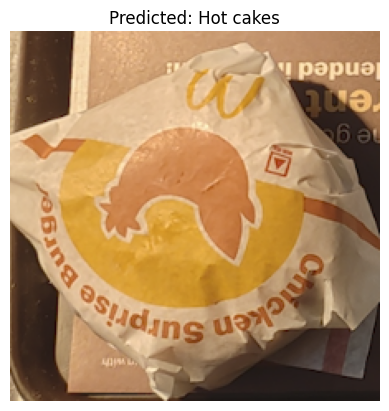

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


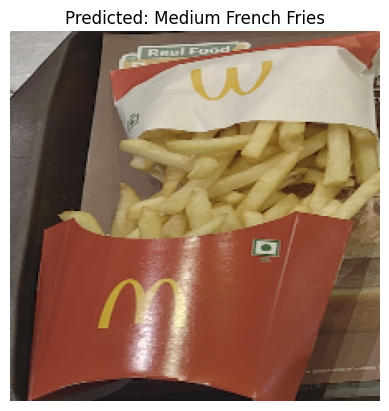

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


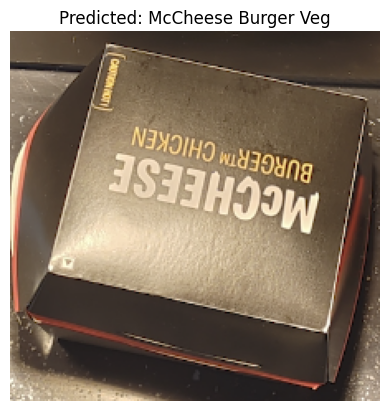

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


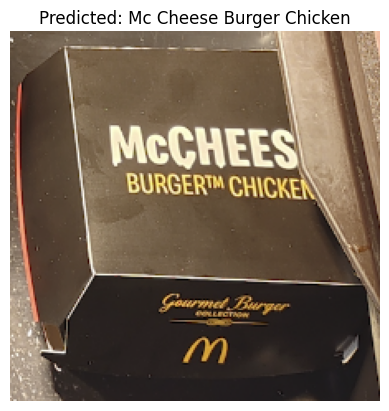

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


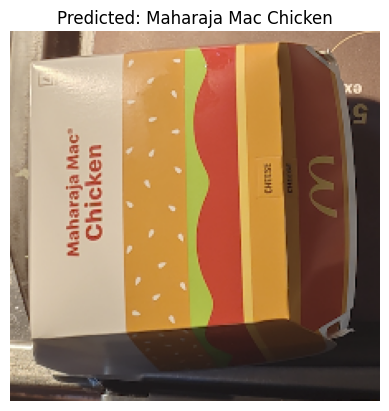

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


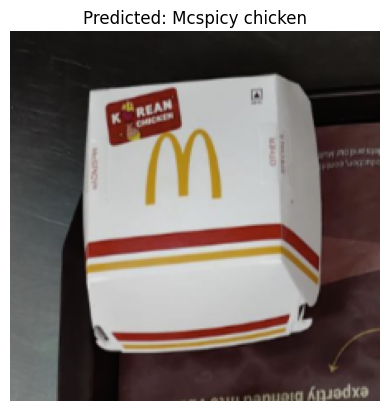

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


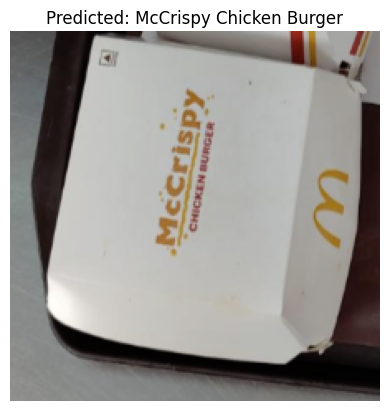

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


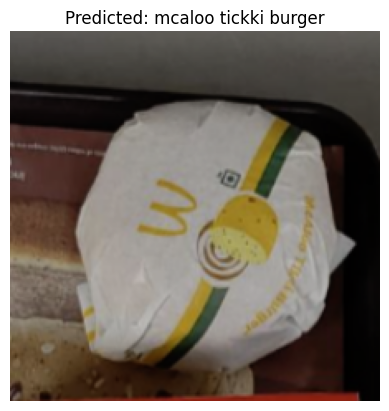

In [ ]:
# Create inverse mapping for labels
inverse_labels = class_names
num_classes = len(class_names)

# Loop through test samples
for i in range(1, 19):
    pth = f'/Users/saptarshimallikthakur/Desktop/tracking/McD /SSD 300/ss/ss{i}.png'
    img = load_and_preprocess_image(pth)
    input_img = np.expand_dims(img, axis=0)  # Add batch dimension

    pred_probs = model.predict(input_img)
    pred_label_idx = np.argmax(pred_probs[0])
    pred_label = inverse_labels[pred_label_idx]

    plt.imshow(img.astype('uint8'))
    plt.title(f"Predicted: {pred_label}")
    plt.axis('off')
    plt.show()

# ONNX

In [1]:
class_names

NameError: name 'class_names' is not defined